In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df_clustered = pd.read_json('df_slim_rotterdam_clustered.json', orient='records', lines=True)
df_clustered.head()

,navigation.time,navigation.location.long,navigation.location.lat,navigation.destination.name,navigation.destination.eta,navigation.status,device.mmsi,vessel.type,vessel.imo,vessel.name,day,hour,minute,cluster
0,1609459588000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,6,2
1,1609459769000,4.00827,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,9,2
2,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,2
3,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,2
4,1609460669000,4.00828,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,24,2


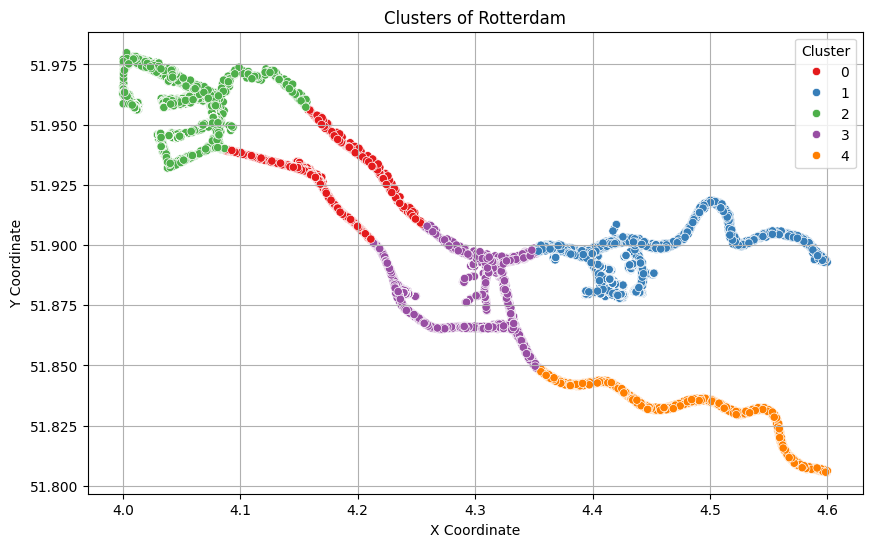

In [3]:
# plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Clusters of Rotterdam')

sns.scatterplot(data=df_clustered, x='navigation.location.long', y='navigation.location.lat', hue='cluster', palette='Set1')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [6]:
split1 =[2, 1, 4]
split2 = [0, 3]

# create dataframe with only clusters in split2
df_split2 = df_clustered[df_clustered['cluster'].isin(split2)].copy()

# create dataframe with only clusters in split1
df_split1 = df_clustered[df_clustered['cluster'].isin(split1)].copy()

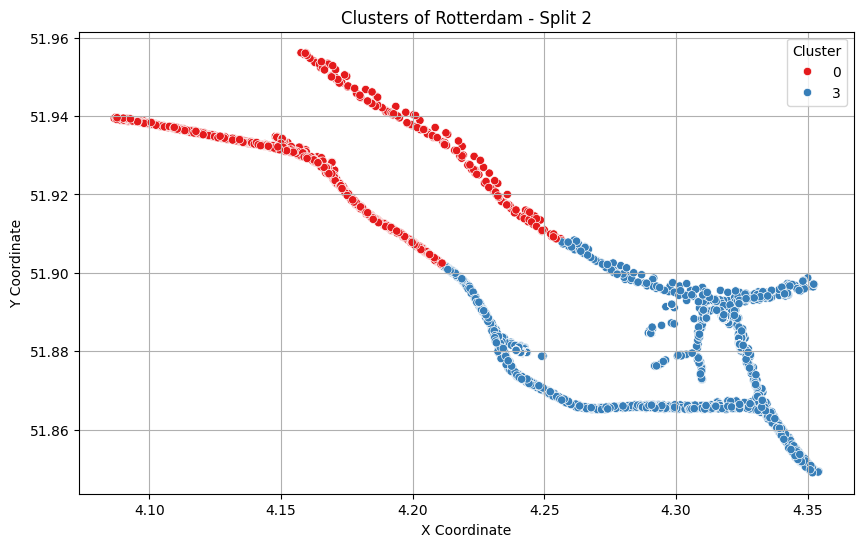

In [7]:
# plot df_split2
plt.figure(figsize=(10, 6))
plt.title('Clusters of Rotterdam - Split 2')

sns.scatterplot(data=df_split2, x='navigation.location.long', y='navigation.location.lat', hue='cluster', palette='Set1')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [ ]:
# values estimated from the map
point1 = (4.15, 51.944)
point2 = (4.275, 51.87)

# function which goes through the points
def line_function(x):
    return (point2[1] - point1[1]) / (point2[0] - point1[0]) * (x - point1[0]) + point1[1]


def redistribute(x, y):
    cluster = None
    if x < point1[0]:
        cluster = 3
    elif y < point2[1]:
        cluster = 3
    elif y > line_function(x):
        cluster = 0
    else:
        cluster = 3
    return cluster

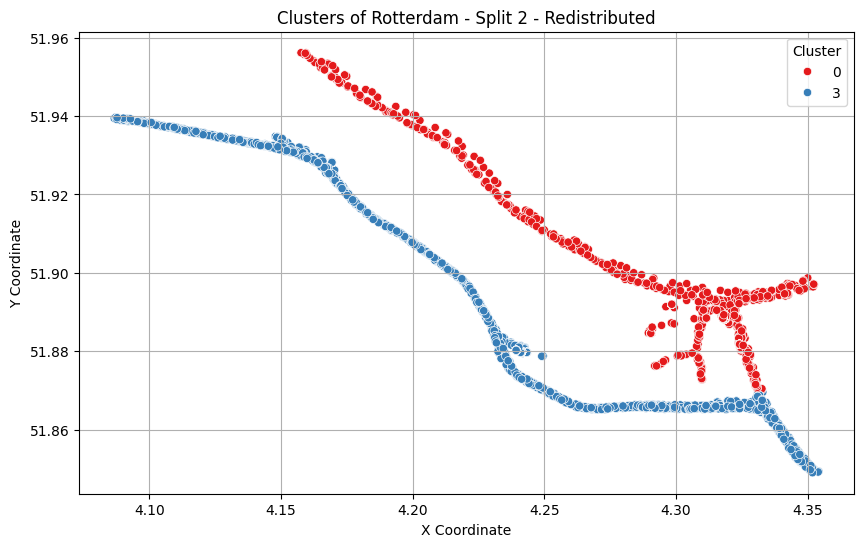

In [11]:
# redistribute the datapoints with the redistribute function
df_split2['cluster'] = df_split2.apply(lambda row: redistribute(row['navigation.location.long'], row['navigation.location.lat']), axis=1)
# plot df_split2
plt.figure(figsize=(10, 6))
plt.title('Clusters of Rotterdam - Split 2 - Redistributed')

sns.scatterplot(data=df_split2, x='navigation.location.long', y='navigation.location.lat', hue='cluster', palette='Set1')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [12]:
# combine new split2 and old split1
df_combined = pd.concat([df_split1, df_split2], ignore_index=True)

# claculate cebntroid of the clusters
def calculate_centroid(cluster):
    """
    Calculate the centroid of the cluster.
    """
    x = df_combined[df_combined['cluster'] == cluster]['navigation.location.long'].mean()
    y = df_combined[df_combined['cluster'] == cluster]['navigation.location.lat'].mean()
    return (x, y)

# calculate the centroids of the clusters
centroids = {}
for cluster in df_combined['cluster'].unique():
    centroids[cluster] = calculate_centroid(cluster)
print(centroids)


{2: (4.032490189877836, 51.955837944851666), 1: (4.433256478916589, 51.88666998768852), 4: (4.481643186813186, 51.831440549450555), 0: (4.305274510571653, 51.88374765465936), 3: (4.213712776603241, 51.9014291789993)}


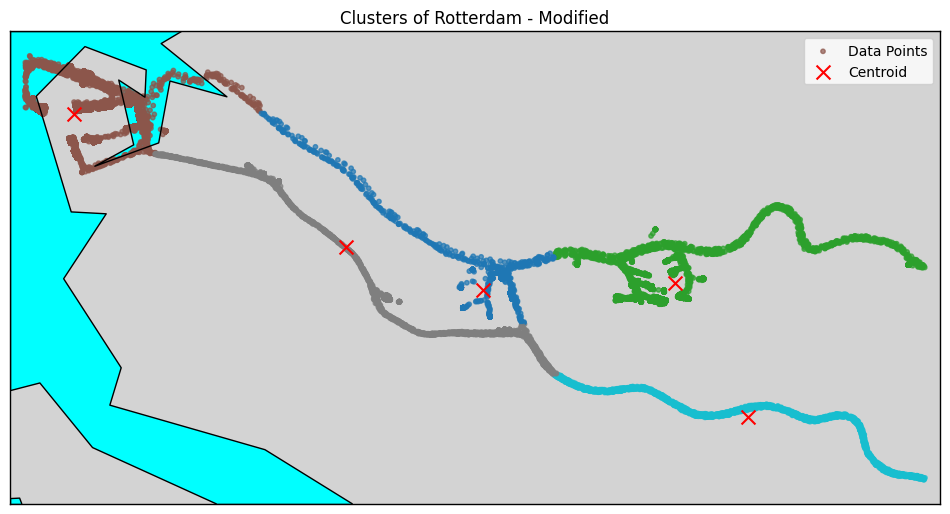

In [13]:
from mpl_toolkits.basemap import Basemap

# Initialize Basemap
plt.figure(figsize=(12, 8))
m = Basemap(projection='merc', 
            llcrnrlat=df_combined['navigation.location.lat'].min() - 0.01, 
            urcrnrlat=df_combined['navigation.location.lat'].max() + 0.01,
            llcrnrlon=df_combined['navigation.location.long'].min() - 0.01, 
            urcrnrlon=df_combined['navigation.location.long'].max() + 0.01,
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgrey', lake_color='aqua')

x, y = m(df_combined['navigation.location.long'].values, df_combined['navigation.location.lat'].values)
m.scatter(x, y, c=df_combined['cluster'], cmap='tab10', s=10, marker='o', alpha=0.7, label='Data Points')

# Plot centroids
for i, (cluster, (lon, lat)) in enumerate(centroids.items()):
    x, y = m(lon, lat)
    if i == 0:  # Add label only once
        m.scatter(x, y, c='red', s=100, marker='x', label='Centroid')
    else:
        m.scatter(x, y, c='red', s=100, marker='x')

plt.legend()

plt.title('Clusters of Rotterdam - Modified')
plt.show()


In [14]:
# save the combined dataframe to a json file
df_combined.to_json('df_slim_rotterdam_modified.json', orient='records', lines=True)
